In [1]:
import cpr_gym
import itertools
import git
import gym
import numpy as np
import os
import pandas as pd
import pathlib
import seaborn as sns
import time
import warnings
from pandarallel import pandarallel
from stable_baselines3 import PPO

pandarallel.initialize(progress_bar=True)

print("cpr_lib_version: " + cpr_gym.engine.cpr_lib_version)

repo = git.Repo(".", search_parent_directories=True)
repo.working_tree_dir
os.chdir(repo.working_tree_dir)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
cpr_lib_version: local-v0.4-98-gd9b2ba4-dirty


# Run simulations with trained models

In [2]:
def models():
    for m in pathlib.Path("data/models").glob("*-sb3-ppo-*.zip"):
        x = m.stem.split("-sb3-ppo-")
        y = x[1].split("-")
        protocol = y[0]
        if protocol == "nakamoto":
            yield dict(
                model=x[0],
                protocol=y[0],
                k=1,
                reward="btc",
                subblock_selection="n/a",
                gamma=int(y[1].removeprefix("gamma")) / 100,
                path=m,
            )
        elif protocol == "tailstorm" or protocol == "tailstormll":
            yield dict(
                model=x[0],
                protocol=y[0],
                k=int(y[1]),
                reward=y[2],
                subblock_selection=y[3],
                gamma=int(y[4].removeprefix("gamma")) / 100,
                path=m,
            )
        else:
            raise Exception(f"unsupported protocol: {protocol}")


models = pd.DataFrame(models())
models = pd.concat(
    [
        models.assign(kind="trained"),
        models.query(
            'protocol == "tailstorm" and subblock_selection == "heuristic"'
        ).assign(kind="reused", subblock_selection="optimal"),
    ],
    ignore_index=True,
)
models

,model,protocol,k,reward,subblock_selection,gamma,path,kind
0,wandb-294,nakamoto,1,btc,n/a,0.5,data/models/wandb-294-sb3-ppo-nakamoto-gamma50...,trained
1,wandb-291,nakamoto,1,btc,n/a,0.5,data/models/wandb-291-sb3-ppo-nakamoto-gamma50...,trained
2,wandb-337,tailstorm,8,constant,heuristic,0.5,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,trained
3,wandb-337,tailstorm,8,constant,optimal,0.5,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,reused


In [3]:
protocols = dict(
    nakamoto=(cpr_gym.protocols.nakamoto, []),
    tailstorm=(cpr_gym.protocols.tailstorm, ["k", "reward", "subblock_selection"]),
    tailstormll=(cpr_gym.protocols.tailstormll, ["k", "reward", "subblock_selection"]),
)
episode_len = 2048
n_episodes = 10
alpha = np.arange(0.1, 0.501, 0.025)


def episodes():
    for i in range(0, n_episodes):
        for a in alpha:
            yield models.assign(episode=i, alpha=a)


episodes = pd.concat(episodes(), ignore_index=True)


def sparse_env(x):
    proto, proto_args = protocols[x.protocol]
    proto_args = {k: x[k] for k in proto_args}
    env = gym.make(
        "cpr_gym:core-v0",
        proto=proto(**proto_args),
        gamma=x.gamma,
        alpha=x.alpha,
        max_time=episode_len,
        max_steps=episode_len * 10000,
    )
    return env


loaded = {}


def load(path):
    if path in loaded.keys():
        return loaded[path]
    else:
        m = PPO.load(path)
        loaded[path] = m
        return m


def observe_episode(info):
    return pd.Series(
        {
            k: info[k]
            for k in [
                "episode_reward_attacker",
                "episode_chain_time",
                "episode_progress",
            ]
        }
    )


def measure(x):
    env = sparse_env(x)
    model = load(x.path)
    obs = env.reset()
    done = False
    while not done:
        extobs = np.append(obs, [x.alpha])
        action, _ = model.predict(extobs, deterministic=True)
        obs, _reward, done, info = env.step(action)
    return observe_episode(info)


# run simulations
results = episodes.parallel_apply(
    measure,
    axis=1,
)
rl_episodes = pd.concat([episodes, results], axis=1)
rl_episodes

,model,protocol,k,reward,subblock_selection,gamma,path,kind,episode,alpha,episode_reward_attacker,episode_chain_time,episode_progress
0,wandb-294,nakamoto,1,btc,n/a,0.5,data/models/wandb-294-sb3-ppo-nakamoto-gamma50...,trained,0,0.100,107.0,2047.961627,1837.0
1,wandb-291,nakamoto,1,btc,n/a,0.5,data/models/wandb-291-sb3-ppo-nakamoto-gamma50...,trained,0,0.100,205.0,2048.556180,2067.0
2,wandb-337,tailstorm,8,constant,heuristic,0.5,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,trained,0,0.100,213.0,2046.877924,2000.0
3,wandb-337,tailstorm,8,constant,optimal,0.5,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,reused,0,0.100,194.0,2043.811318,2048.0
4,wandb-294,nakamoto,1,btc,n/a,0.5,data/models/wandb-294-sb3-ppo-nakamoto-gamma50...,trained,0,0.125,164.0,2049.180238,1738.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,wandb-337,tailstorm,8,constant,optimal,0.5,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,reused,9,0.475,971.0,2047.230542,1176.0
676,wandb-294,nakamoto,1,btc,n/a,0.5,data/models/wandb-294-sb3-ppo-nakamoto-gamma50...,trained,9,0.500,1039.0,2047.926696,1066.0
677,wandb-291,nakamoto,1,btc,n/a,0.5,data/models/wandb-291-sb3-ppo-nakamoto-gamma50...,trained,9,0.500,981.0,2048.258366,1073.0
678,wandb-337,tailstorm,8,constant,heuristic,0.5,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,trained,9,0.500,996.0,2039.299027,1080.0


## Patrik-style rewards

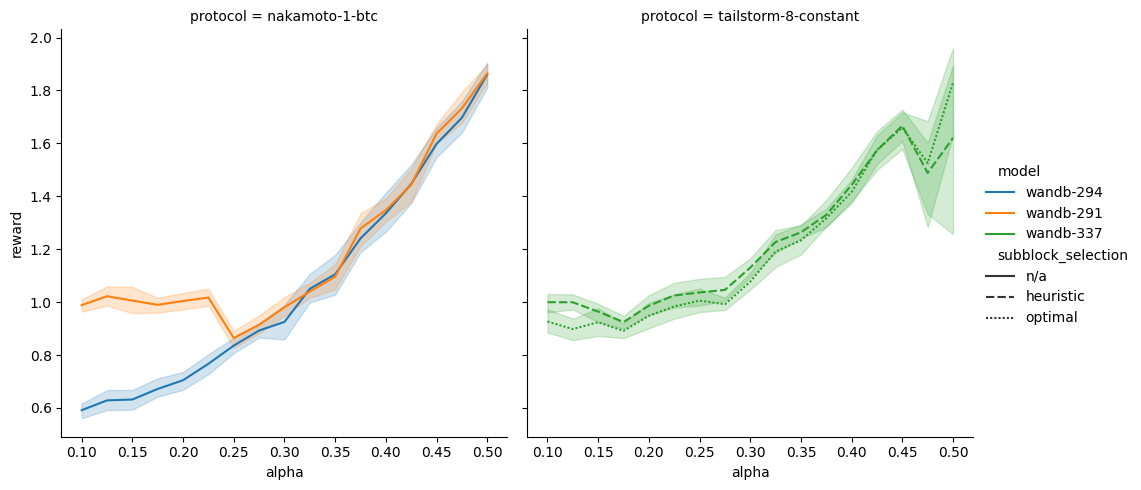

In [4]:
d = rl_episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress / d.alpha,
    ),
    kind="line",
    x="alpha",
    y="reward",
    hue="model",
    style="subblock_selection",
    col="protocol",
)

## Ben-style rewards

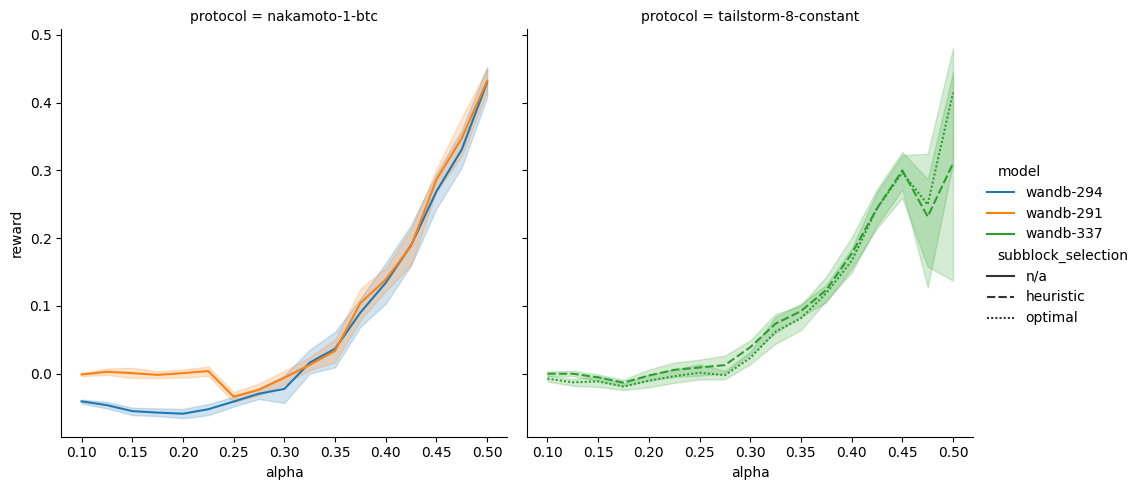

In [5]:
d = rl_episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress - d.alpha,
    ),
    kind="line",
    x="alpha",
    y="reward",
    hue="model",
    style="subblock_selection",
    col="protocol",
)

# Simulate hard-coded policies

In [6]:
scenarios = models[
    ["protocol", "k", "reward", "subblock_selection", "gamma"]
].drop_duplicates()


def episodes():
    for _idx, x in scenarios.iterrows():
        x = x.copy()
        x["alpha"] = 0.0
        env = sparse_env(x)
        for p in env.policies():
            for i in range(0, n_episodes):
                for a in alpha:
                    x = x.copy()
                    x["policy"] = p
                    x["alpha"] = a
                    x["episode"] = i
                    yield x


episodes = pd.DataFrame(episodes()).reset_index(drop=True)


def measure(x):
    env = sparse_env(x)
    obs = env.reset()
    done = False
    while not done:
        action = env.policy(obs, x.policy)
        obs, reward, done, info = env.step(action)
    return observe_episode(info)


# run simulations
results = episodes.parallel_apply(
    measure,
    axis=1,
)
hc_episodes = pd.concat([episodes, results], axis=1)
hc_episodes

,protocol,k,reward,subblock_selection,gamma,alpha,policy,episode,episode_reward_attacker,episode_chain_time,episode_progress
0,nakamoto,1,btc,n/a,0.5,0.100,sapirshtein-2016-sm1,0,129.0,2047.837373,1851.0
1,nakamoto,1,btc,n/a,0.5,0.125,sapirshtein-2016-sm1,0,181.0,2048.769368,1852.0
2,nakamoto,1,btc,n/a,0.5,0.150,sapirshtein-2016-sm1,0,194.0,2048.506691,1804.0
3,nakamoto,1,btc,n/a,0.5,0.175,sapirshtein-2016-sm1,0,264.0,2046.231747,1776.0
4,nakamoto,1,btc,n/a,0.5,0.200,sapirshtein-2016-sm1,0,316.0,2050.319568,1688.0
...,...,...,...,...,...,...,...,...,...,...,...
2035,tailstorm,8,constant,optimal,0.5,0.400,honest,9,810.0,2046.867126,2024.0
2036,tailstorm,8,constant,optimal,0.5,0.425,honest,9,862.0,2047.095087,1992.0
2037,tailstorm,8,constant,optimal,0.5,0.450,honest,9,887.0,2044.765408,2024.0
2038,tailstorm,8,constant,optimal,0.5,0.475,honest,9,964.0,2042.340927,2064.0


# Determine best hard-coded policies

In [7]:
key = ["protocol", "k", "reward", "subblock_selection", "gamma", "alpha"]
d = hc_episodes
d = d.assign(episode_reward=d.episode_reward_attacker / d.episode_progress)
mean_reward = d.groupby(key + ["policy"]).episode_reward.mean().reset_index()
opt_idx = mean_reward.reset_index().groupby(key).episode_reward.idxmax()
opt_policies = mean_reward.iloc[opt_idx].set_index(key)
opt_policies

policy  \
protocol  k reward   subblock_selection gamma alpha                         
nakamoto  1 btc      n/a                0.5   0.100                honest   
                                              0.125                honest   
                                              0.150                honest   
                                              0.175                honest   
                                              0.200                honest   
                                              0.225                honest   
                                              0.250                honest   
                                              0.275       eyal-sirer-2014   
                                              0.300       eyal-sirer-2014   
                                              0.325       eyal-sirer-2014   
                                              0.350       eyal-sirer-2014   
                                              0.375       eyal-sirer-2014   
                                              0.400  sapirshtein-2016-sm1   
                                              0.425  sapirshtein-2016-sm1   
                                              0.450  sapirshtein-2016-sm1   
                                              0.475  sapirshtein-2016-sm1   
                                              0.500       eyal-sirer-2014   
tailstorm 8 constant heuristic          0.5   0.100                honest   
                                              0.125         release-block   
                                              0.150                honest   
                                              0.175         release-block   
                                              0.200         release-block   
                                              0.225                honest   
                                              0.250                honest   
                                              0.275                honest   
                                              0.300                honest   
                                              0.325                honest   
                                              0.350      override-catchup   
                                              0.375      override-catchup   
                                              0.400      override-catchup   
                                              0.425      override-catchup   
                                              0.450      override-catchup   
                                              0.475      override-catchup   
                                              0.500      override-catchup   
                     optimal            0.5   0.100                honest   
                                              0.125         release-block   
                                              0.150                honest   
                                              0.175         release-block   
                                              0.200         release-block   
                                              0.225                honest   
                                              0.250                honest   
                                              0.275                honest   
                                              0.300                honest   
                                              0.325                honest   
                                              0.350      override-catchup   
                                              0.375      override-catchup   
                                              0.400      override-catchup   
                                              0.425      override-catchup   
                                              0.450      override-catchup   
                                              0.475      override-catchup   
                                              0.500      overri

In [8]:
mhc_episodes = (
    hc_episodes.join(opt_policies.policy, on=key, rsuffix="_opt")
    .query("policy == policy_opt")
    .reset_index(drop=True)
    .drop(columns=["policy_opt"])
    .assign(model="max-hard-coded", kind="hard-coded")
)
episodes = pd.concat([rl_episodes, mhc_episodes], axis=0, ignore_index=True)
episodes

,model,protocol,k,reward,subblock_selection,gamma,path,kind,episode,alpha,episode_reward_attacker,episode_chain_time,episode_progress,policy
0,wandb-294,nakamoto,1,btc,n/a,0.5,data/models/wandb-294-sb3-ppo-nakamoto-gamma50...,trained,0,0.100,107.0,2047.961627,1837.0,NaN
1,wandb-291,nakamoto,1,btc,n/a,0.5,data/models/wandb-291-sb3-ppo-nakamoto-gamma50...,trained,0,0.100,205.0,2048.556180,2067.0,NaN
2,wandb-337,tailstorm,8,constant,heuristic,0.5,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,trained,0,0.100,213.0,2046.877924,2000.0,NaN
3,wandb-337,tailstorm,8,constant,optimal,0.5,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,reused,0,0.100,194.0,2043.811318,2048.0,NaN
4,wandb-294,nakamoto,1,btc,n/a,0.5,data/models/wandb-294-sb3-ppo-nakamoto-gamma50...,trained,0,0.125,164.0,2049.180238,1738.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,max-hard-coded,tailstorm,8,constant,optimal,0.5,NaN,hard-coded,9,0.225,475.0,2040.045192,2080.0,honest
1186,max-hard-coded,tailstorm,8,constant,optimal,0.5,NaN,hard-coded,9,0.250,546.0,2045.396410,2064.0,honest
1187,max-hard-coded,tailstorm,8,constant,optimal,0.5,NaN,hard-coded,9,0.275,522.0,2046.322941,1992.0,honest
1188,max-hard-coded,tailstorm,8,constant,optimal,0.5,NaN,hard-coded,9,0.300,604.0,2046.224267,2080.0,honest


# Compare RL against best hard-coded

## Reward per progress (in DAA equilibrium)

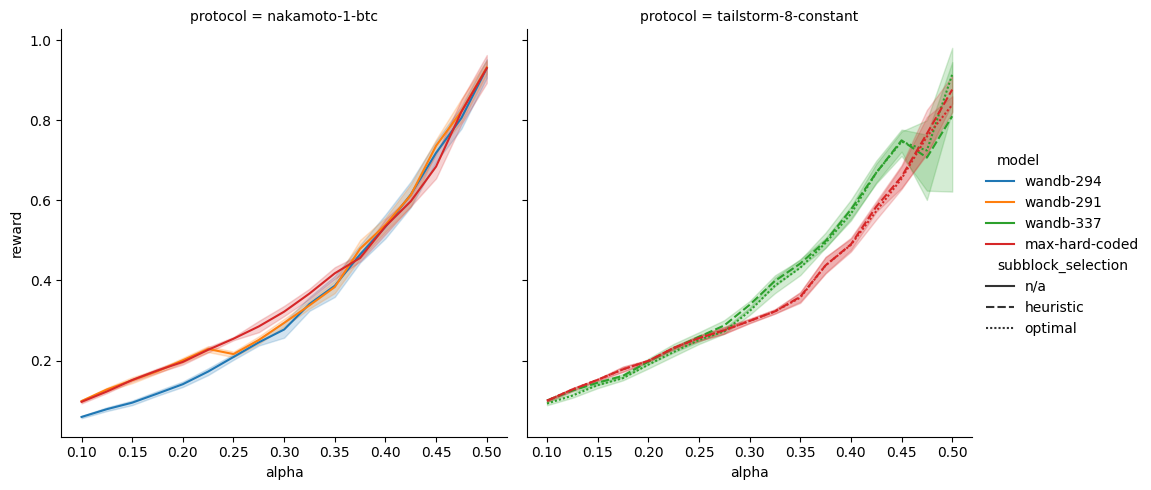

In [9]:
d = episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress,
    ),
    kind="line",
    x="alpha",
    y="reward",
    hue="model",
    style="subblock_selection",
    col="protocol",
)

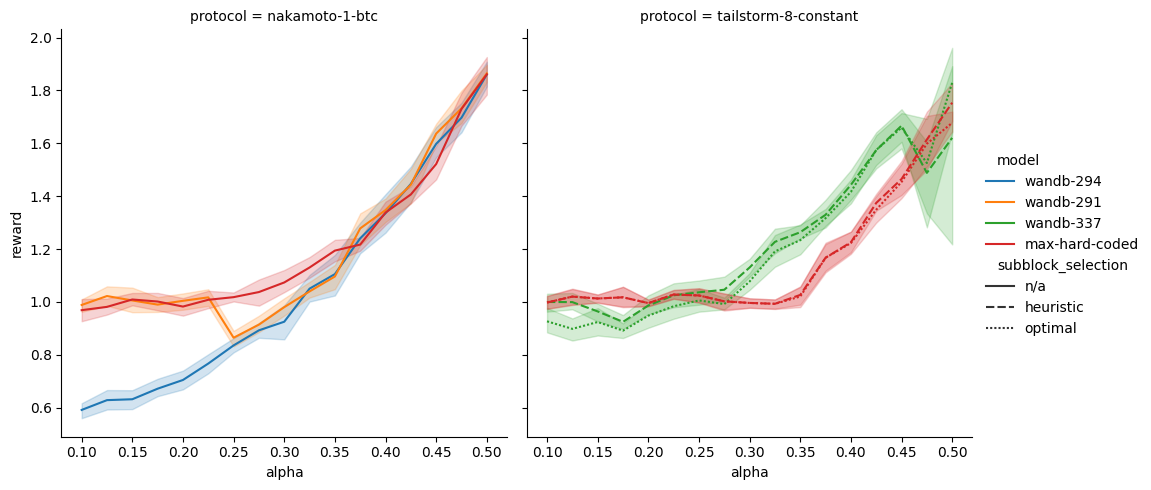

In [10]:
d = episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress / d.alpha,
    ),
    kind="line",
    x="alpha",
    y="reward",
    hue="model",
    style="subblock_selection",
    col="protocol",
)

## Reward, Ben-style

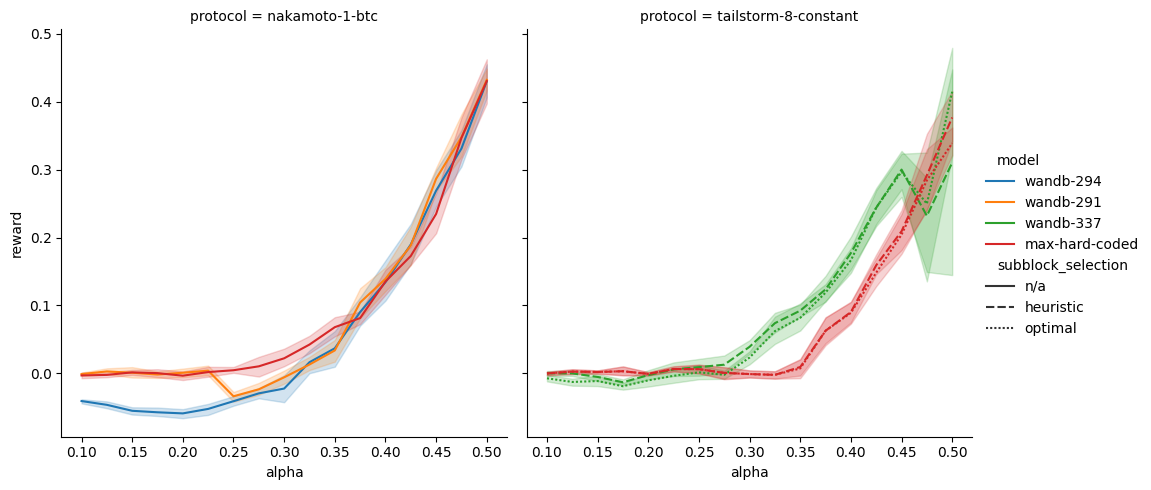

In [11]:
d = episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress - d.alpha,
    ),
    kind="line",
    x="alpha",
    y="reward",
    hue="model",
    style="subblock_selection",
    col="protocol",
)

## Orphans

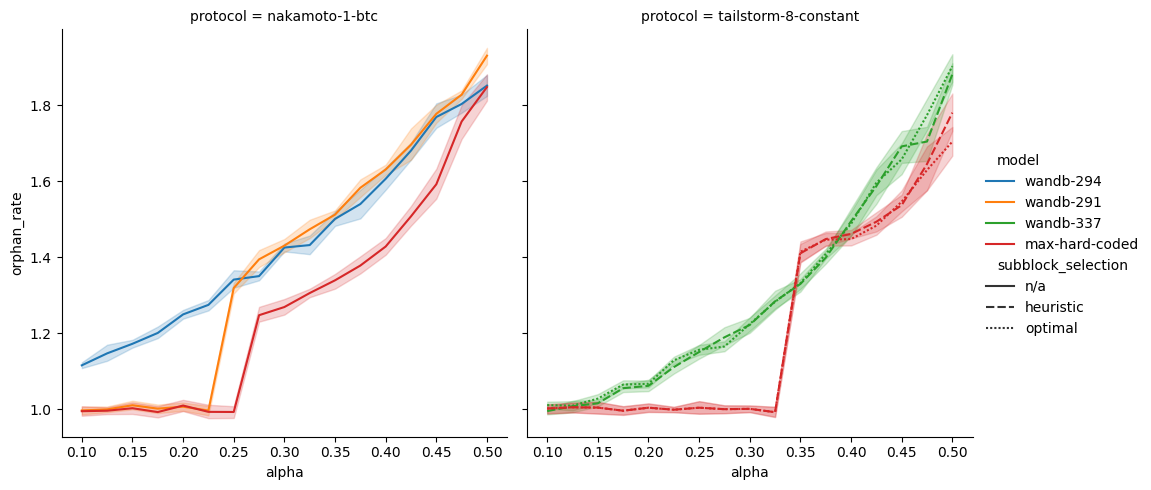

In [12]:
d = episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        orphan_rate=d.episode_chain_time / d.episode_progress,
    ),
    kind="line",
    x="alpha",
    y="orphan_rate",
    hue="model",
    style="subblock_selection",
    col="protocol",
)